In [2]:
# Enabling and testing the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Installing TensorFlow Docs
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [6]:
# Import all the required libraries
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [7]:
# Training Dataset
train_df = pd.read_csv("./gdrive/My Drive/video_classification/train.csv")
Train_Directory = './gdrive/My Drive/video_classification/train/'
print(f"Total videos for training: {len(train_df)}")

Total videos for training: 355


In [8]:
# Display a sample in the train.csv
train_df.sample(10)

,video_name,tag
159,v_ShavingBeard_g14_c03.avi,ShavingBeard
243,v_TennisSwing_g08_c06.avi,TennisSwing
266,v_TennisSwing_g12_c02.avi,TennisSwing
195,v_ShavingBeard_g19_c06.avi,ShavingBeard
39,v_PlayingCello_g13_c06.avi,PlayingCello
120,v_ShavingBeard_g08_c01.avi,ShavingBeard
12,v_PlayingCello_g09_c07.avi,PlayingCello
10,v_PlayingCello_g09_c05.avi,PlayingCello
214,v_ShavingBeard_g22_c04.avi,ShavingBeard
33,v_PlayingCello_g12_c07.avi,PlayingCello


In [10]:
# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(num_oov_indices=0,vocabulary=np.unique(train_df["tag"]),mask_token=None)
print(label_processor.get_vocabulary())

['PlayingCello', 'ShavingBeard', 'TennisSwing']


In [11]:
# Crop images
IMG_SIZE = 128
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)
def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

In [12]:
# Processing video frames
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [13]:
# Feature Extraction
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(weights="imagenet",
                                                       include_top=False,
                                                       pooling="avg",
                                                       input_shape=(IMG_SIZE, IMG_SIZE, 3),)
    preprocess_input = keras.applications.densenet.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")
feature_extractor = build_feature_extractor()

29084464/29084464 [==============================] - 3s 0us/step


In [ ]:
# Data processing utility
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),
                              dtype="float32")
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)
        frames = frames[None, ...]
        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                                       dtype="float32")
        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
                else:
                    temp_frame_features[i, j, :] = 0.0
        frame_features[idx,] = temp_frame_features.squeeze()
    return frame_features, labels
train_data, train_labels = prepare_all_videos(train_df, Train_Directory)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 64ms/step
Frame features in train set: (20, 1024)
Frame masks in train set: (20, 1024)


In [ ]:
# Building the Transformer-based model
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=output_dim)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions
    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim,
                                                   dropout=0.3)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation=tf.nn.gelu),
                                            layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
# Compilation
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())
    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(sequence_length, embed_dim,
                            name="frame_position_embedding")(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
# Callbacks and Training
EPOCHS = 13
def run_experiment():
    filepath = "./gdrive/My Drive/video_classification/video_weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 save_best_only=True, verbose=1)
    model = get_compiled_model()
    history = model.fit(train_data, train_labels, validation_split=0.15, epochs=EPOCHS,
                        callbacks=[checkpoint,
                                   keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                 patience=10),],)
    model.load_weights(filepath)
    return model
trained_model = run_experiment()

Epoch 1/13
 8/10 [=======================>......] - ETA: 0s - loss: 2.6211 - accuracy: 0.5742
Epoch 1: val_loss improved from inf to 0.00028, saving model to ./gdrive/My Drive/video_classification/video_weights.h5
10/10 [==============================] - 7s 205ms/step - loss: 2.2364 - accuracy: 0.6346 - val_loss: 2.8164e-04 - val_accuracy: 1.0000
Epoch 2/13
 9/10 [==========================>...] - ETA: 0s - loss: 0.1069 - accuracy: 0.9653
Epoch 2: val_loss improved from 0.00028 to 0.00000, saving model to ./gdrive/My Drive/video_classification/video_weights.h5
10/10 [==============================] - 0s 28ms/step - loss: 0.1023 - accuracy: 0.9668 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/13
 9/10 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
10/10 [==============================] - 0s 20ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/13
 9/10 [======

In [ ]:
# Model architecture
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 1024)       20480     
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, None, 1024)       4211716   
 merEncoder)                                                     
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

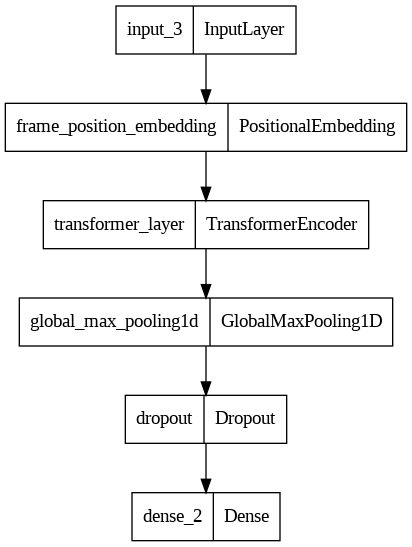

In [ ]:
# Model visualization
plot_model(trained_model, to_file='model.png')

In [ ]:
# Prediction
predict_df = pd.read_csv("./gdrive/My Drive/video_classification/predict.csv")
Predict_Directory = './gdrive/My Drive/video_classification/predict/'
print(f"Total videos for testing: {len(predict_df)}")

# Helper functions
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)
    frames = frames[None, ...]
    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0
    return frame_features
def predict_action(path):
    class_vocab = label_processor.get_vocabulary()
    frames = load_video(os.path.join(Predict_Directory, path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    return frames

# Custom prediction
arr = np.array(predict_df["video_name"].values.tolist())
for i in range(0,len(arr)):
  predict_video = arr[i]
  print(f"Predict video path: {predict_video}")
  predict_frames = predict_action(predict_video)

Total videos for testing: 3
Predict video path: v_PlayingCello_g04_c02.avi
1/1 [==============================] - 0s 21ms/step
  PlayingCello: 100.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
Predict video path: v_ShavingBeard_g03_c01.avi
1/1 [==============================] - 0s 22ms/step
  ShavingBeard: 100.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
Predict video path: v_TennisSwing_g05_c07.avi
1/1 [==============================] - 0s 20ms/step
  TennisSwing: 100.00%
  ShavingBeard:  0.00%
  PlayingCello:  0.00%
